In [ ]:
import fiftyone as fo

In [ ]:
# Load the dataset from Hugging Face if it's your first time using it
# import fiftyone.utils.huggingface as fouh

# train_dataset = fouh.load_from_hub(
# "Voxel51/Coursera_lecture_dataset_train", 
# dataset_name="lecture_dataset_train", 
# persistent=True)


# test_dataset = fouh.load_from_hub(
# "Voxel51/Coursera_lecture_dataset_test", 
# dataset_name="lecture_dataset_test", 
# persistent=True)

In [ ]:
#because I have the dataset saved locally, I will load it like so
train_dataset = fo.load_dataset("lecture_dataset_train")

# and just cloning it as I don't want to modify the original
train_dataset = train_dataset.clone(name="lecture-train-clone")

test_dataset = fo.load_dataset(name="lecture_dataset_test")
test_dataset = test_dataset.clone(name="lecture-test-clone")

### Bounding Box Analysis

Note: that FiftyOne Detections are relative bounding box coordinates in [0, 1] in the following format:`[top-left-x, top-left-y, width, height]`

Let's break down the next code block intuitively:

* `rel_bbox_area = F("bounding_box")[2] * F("bounding_box")[3]`
   This calculates the relative area of a bounding box. In FiftyOne, bounding boxes are typically stored as `[x, y, width, height]` where x and y are the coordinates of the top-left corner, and width and height are relative to the image size (values between 0 and 1). So this line multiplies the relative width and height to get the relative area.

* `im_width, im_height = F("$metadata.width"), F("$metadata.height")`
   This retrieves the actual width and height of each image from the metadata. The "$" indicates that we're accessing a field at the sample level, not within a detection.

* `abs_area = rel_bbox_area * im_width * im_height`
   This calculates the absolute area of the bounding box in pixels. It does this by multiplying the relative area by the image dimensions.

* `train_dataset.set_field("ground_truth.detections.relative_bbox_area", rel_bbox_area).save()`
   This adds a new field to each detection in the ground truth, storing the relative area of the bounding box.

* `train_dataset.set_field("ground_truth.detections.absolute_bbox_area", abs_area).save()`
   This adds another new field to each detection, this time storing the absolute area of the bounding box in pixels.

In essence, this code is adding two new pieces of information to each detection in our dataset:

1. The relative area of the bounding box (as a fraction of the total image area)

2. The absolute area of the bounding box (in pixels)

These new fields can be very useful for further analysis, such as filtering detections based on their size, or analyzing the distribution of object sizes in your dataset. The beauty of using `ViewField` (`F`) is that these calculations are done efficiently across the entire dataset without needing to iterate through each sample manually.

In [ ]:
from fiftyone import ViewField as F

rel_bbox_area = F("bounding_box")[2] * F("bounding_box")[3]

im_width, im_height = F("$metadata.width"), F("$metadata.height")

abs_area = rel_bbox_area * im_width * im_height

train_dataset.set_field("ground_truth.detections.relative_bbox_area", rel_bbox_area).save()

train_dataset.set_field("ground_truth.detections.absolute_bbox_area", abs_area).save()

In [ ]:
train_dataset.first().ground_truth.detections[0]

You can compute the upper and lower [bounds](https://docs.voxel51.com/api/fiftyone.core.aggregations.html#fiftyone.core.aggregations.Bounds) of the bounding box areas as well as other summary statistics like mean and standard deviation. Note: these are relative bounding box areas, so they represent the percentage of the total image area (hence the multiply by 100).

Here's how you can do that:



In [ ]:
labels = train_dataset.distinct("ground_truth.detections.label")

for label in labels:
    view = train_dataset.filter_labels("ground_truth", F("label") == label)
    bounds = view.bounds("ground_truth.detections.relative_bbox_area")
    bounds = (bounds[0]*100, bounds[1]*100)
    area = view.mean("ground_truth.detections.relative_bbox_area")*100
    std = view.std("ground_truth.detections.relative_bbox_area")
    print("\033[1m%s:\033[0m Min: %.4f, Mean: %.4f, Std: %.4f, Max: %.4f" % (label, bounds[0], std, area, bounds[1]))

### Visualize the distribution of bounding box sizes across different classes.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get all labels and relative bbox areas
labels = train_dataset.values("ground_truth.detections.label")

bbox_areas = train_dataset.values("ground_truth.detections.absolute_bbox_area")

# Flatten the lists and create the dataframe
data = []
for sample_labels, sample_areas in zip(labels, bbox_areas):
    for label, area in zip(sample_labels, sample_areas):
        data.append({'label': label, 'absolute_bbox_area': area})

df = pd.DataFrame(data)

plt.figure(figsize=(30, 10))  # Increase figure size

sns.set_style("whitegrid")
sns.set_palette("husl")

ax = sns.boxplot(x='label', y='absolute_bbox_area', data=df, width=0.6)

plt.yscale('log')  # Use log scale for y-axis
plt.ylim(0.001)  # Set y-axis limits

plt.title('Distribution of Relative Bounding Box Areas by Label', fontsize=16)
plt.xlabel('Label', fontsize=16)
plt.ylabel('Relative Bounding Box Area (log scale)', fontsize=16)

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.tight_layout()

plt.show()

# Complex filtering

To filter for samples that have "baseball_cap" labels with a relative_bbox_area less than 0.003 in the ground_truth.detections, you can use [`match_labels`](https://docs.voxel51.com/api/fiftyone.core.dataset.html#fiftyone.core.dataset.Dataset.match_labels) with a combined filter. 

Here's how you can do it:

2. In the `filter` parameter, we combine two conditions:

   - `F("label") == "baseball_cap"`: This checks if the label is "baseball_cap"

   - `F("relative_bbox_area") < 0.003`: This checks if the relative_bbox_area is less than 0.003
   
   - We use the `&` operator to combine these conditions, ensuring both are true

2. The `fields` parameter is set to `"ground_truth.detections"`, specifying where to apply the filter.

This `match_labels` stage will select samples that have at least one detection in `ground_truth.detections` that satisfies both conditions: **it's labeled as "baseball_cap" and has a relative_bbox_area less than 0.003.**

The resulting *filtered view* will contain only the samples from your dataset that have at least one detection labeled as "baseball_cap" with a relative_bbox_area less than 0.003 in the `ground_truth.detections` field.


In [ ]:
filter_to_caps = F("label") == "baseball_cap"

filter_to_small_area_boxes = F("relative_bbox_area") < 0.003

small_baseball_cap_detection = train_dataset.match_labels(
    filter=(filter_to_caps & filter_to_small_area_boxes), 
    fields="ground_truth.detections"
    )

fo.launch_app(small_baseball_cap_detection)

You'll notice that the result above has the labels we wanted to find plus all the other labels in that image. If you only want the labels that meet your requirements and nothing else, you can use [`filter_labels`](https://docs.voxel51.com/api/fiftyone.core.dataset.html#fiftyone.core.dataset.Dataset.filter_labels).


Learn more about filtering in the following resources, as it's required reading. You will have to answer questions based on them:

- [Filtering Tips and Tricks](https://medium.com/voxel51/fiftyone-filtering-tips-and-tricks-dec-09-2022-58ba13500253)

- [View Stage Tips and Tricks](https://medium.com/voxel51/fiftyone-computer-vision-view-stages-tips-and-tricks-january-20-2023-fc3b7f1bb3d4)





In [ ]:
filter_to_only_small_baseball_caps = train_dataset.filter_labels(
    filter=(filter_to_caps & filter_to_small_area_boxes),
    field="ground_truth.detections"
    )

fo.launch_app(filter_to_only_small_baseball_caps)

### Identify images with overlapping bounding boxes or boxes that are very close to each other.

Even without predictions, [`compute_max_ious`](https://docs.voxel51.com/api/fiftyone.utils.iou.html#fiftyone.utils.iou.compute_max_ious) can be a powerful tool for exploring and understanding your dataset. Using `compute_max_ious` in this exploratory way, you're gaining valuable insights into the spatial characteristics of your dataset. This understanding is crucial for making informed decisions about data preprocessing, model selection, and potential challenges in the machine learning pipeline, even before you start training models or generating predictions. 

It's a data-centric approach to understanding the fundamental properties of your visual data. Here's how you can use it to gain insights into your data:

1. Object Analysis:
   - By computing IoUs between objects in the same field (e.g., ground truth), you can understand how much objects in your dataset tend to overlap.
   - High overlap between objects can indicate complex scenes, which might be challenging for models to learn.
   - Low overlap might suggest simpler scenes or more isolated objects.
   - This can reveal patterns in object placement, density, or size in your images
        - Very low IoUs might indicate many small objects, while higher IoUs could suggest larger or more prominent objects.
   - Samples with extreme IoU values (very high or very low) might represent edge cases in your dataset that deserve special attention.

2. Annotation Consistency Check:
   - If you have multiple annotations for the same images (e.g., from different annotators), you can compare them using IoU.
   - This helps identify discrepancies in annotation styles or potential errors.
   - Extremely high IoUs between different objects might indicate duplicate or erroneously split annotations that need correction.   

3. Potential Occlusion Detection:
   - High IoUs between different object classes might indicate frequent occlusions in your dataset.
   - Analyzing IoU distributions across different object classes can reveal if certain classes tend to appear in more crowded or isolated contexts.

In [ ]:
import fiftyone.utils.iou as foui
from fiftyone import ViewField as F

# Compute the maximum IoU for each object in the "ground_truth" field
foui.compute_max_ious(train_dataset, "ground_truth", iou_attr="max_iou", classwise=False)

# Filter labels objects with IoU greater than 0.75, 
view_with_high_ious = train_dataset.filter_labels("ground_truth", F("max_iou") > 0.75)

In [ ]:
fo.launch_app(view_with_high_ious)

### Generate a visualization showing which parts of images tend to have more annotations.

From a data-centric visual AI perspective, analyzing the spatial distribution of objects in your dataset is indeed important for object detection. 

1. Understanding dataset biases:
   - Reveals if certain objects consistently appear in specific image regions
   - Helps identify if the dataset is representative of real-world scenarios or if it has inherent biases
   - Helps in diagnosing false positives or negatives in specific image regions
   - Informs strategies for balancing the dataset not just in terms of class frequency, but also spatial distribution

2. Data augmentation strategies:
   - Informs decisions on how to augment data to improve model generalization
   - For example, if cars are always detected in the lower half of images, you might want to augment data with cars in other positions


However, keep in mind some limitations:

1.Real-world variability: The spatial distribution in your dataset might not perfectly reflect all real-world scenarios.

2. Task-specific relevance: For some object detection tasks, spatial distribution might be less critical than for others.

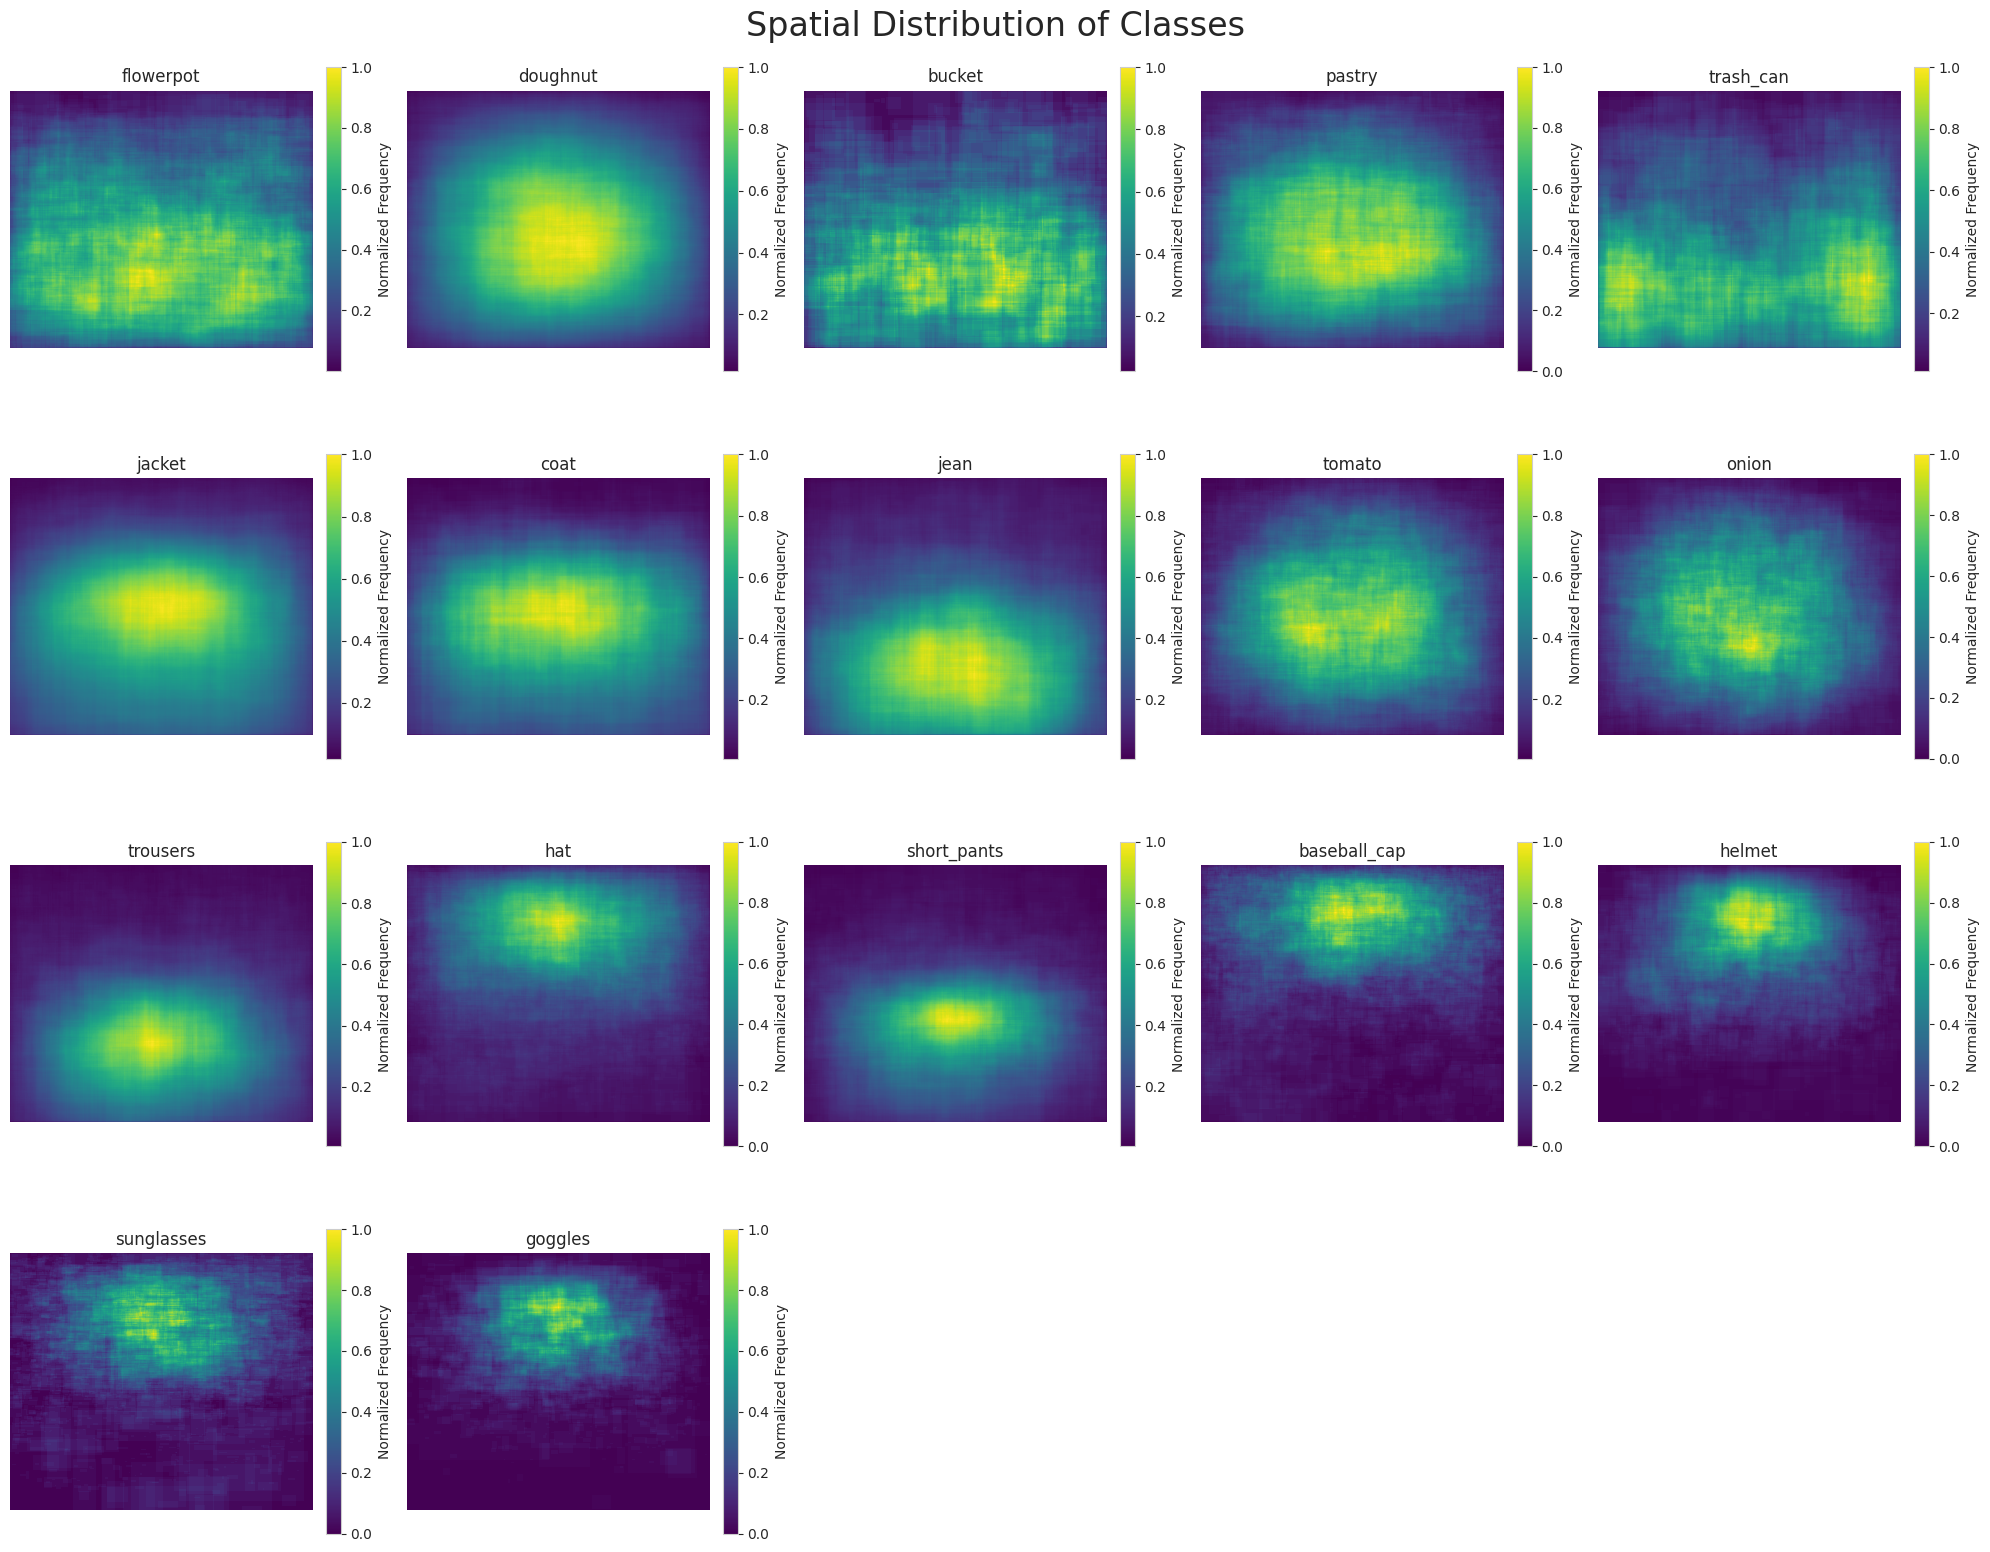

In [145]:
import fiftyone as fo
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from collections import defaultdict

avg_width = int(train_dataset.mean("metadata.width"))
avg_height = int(train_dataset.mean("metadata.height"))

# Set heatmap dimensions
resize_factor = 2
heatmap_width, heatmap_height = avg_width * resize_factor, avg_height * resize_factor

# Initialize a dictionary to store heatmaps for each class
class_heatmaps = defaultdict(lambda: np.zeros((heatmap_height, heatmap_width)))

# Iterate through all samples and their detections
for sample in train_dataset.iter_samples():
    for detection in sample.ground_truth.detections:
        x, y, w, h = detection.bounding_box
        class_label = detection.label
        
        # Convert relative coordinates to pixel coordinates
        x1, y1 = int(x * heatmap_width), int(y * heatmap_height)
        x2, y2 = int((x + w) * heatmap_width), int((y + h) * heatmap_height)
        
        # Add to the class-specific heatmap
        class_heatmaps[class_label][y1:y2, x1:x2] += 1

# Apply Gaussian smoothing and normalize each heatmap

smoothing_sigma = 0.25  # or any other value you choose
for class_label in class_heatmaps:
    class_heatmaps[class_label] = gaussian_filter(class_heatmaps[class_label], sigma=smoothing_sigma)
    class_heatmaps[class_label] /= np.max(class_heatmaps[class_label])

# Sort classes by total frequency
sorted_classes = sorted(class_heatmaps.keys(), key=lambda x: np.sum(class_heatmaps[x]), reverse=True)

# Determine grid size
n_classes = len(sorted_classes)
grid_size = int(np.ceil(np.sqrt(n_classes)))

# Create a big plot with subplots for each class
fig, axes = plt.subplots(grid_size, grid_size, figsize=(4*grid_size, 4*grid_size))
fig.suptitle("Spatial Distribution of Classes", fontsize=24)

for i, class_label in enumerate(sorted_classes):
    ax = axes[i // grid_size, i % grid_size]
    im = ax.imshow(class_heatmaps[class_label], cmap='viridis', interpolation='nearest')
    ax.set_title(class_label)
    ax.axis('off')
    fig.colorbar(im, ax=ax, label='Normalized Frequency', fraction=0.046, pad=0.04)

# Remove any unused subplots
for i in range(n_classes, grid_size * grid_size):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.savefig('all_classes_spatial_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


Object Co-occurrence:
Explore which objects frequently appear together in the same image.
Create a network graph visualizing object co-occurrences.

Multi-label Analysis:
For images with multiple labels, explore label co-occurrences and relationships.

Label Consistency Check:
Identify instances where similar objects might be labeled inconsistently across the dataset.

Advanced Filtering:
Demonstrate complex queries combining multiple criteria (e.g., images with more than X objects of class Y, but no objects of class Z).

# Plugin Ecosystem


Required reading:

- [Using the FiftyOne App](https://docs.voxel51.com/user_guide/app.html#using-the-fiftyone-app)